In [ ]:
#imports
import os
import random
import numpy as np
import pandas as pd
from statistics import mean

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

import torchvision.models as models
from torchvision.models import (
    ResNet50_Weights,
    VGG16_BN_Weights,
    ViT_B_16_Weights,
    efficientnet_b0,
    EfficientNet_B0_Weights,
)

from sklearn.metrics import roc_auc_score

In [ ]:
#Setting seeds for reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [66]:
#Creating train and test splits
def create_train_test_splits(
    summary_csv: str = "data_summary (3).csv",
    test_size: float = 0.15,
    seed: int = 42,
):
    df = pd.read_csv(summary_csv)

    race_map = {"Asian":0, "Black or African American":1, "White":2}
    df["race"] = df["race"].map(race_map)

    df["race_label"] = df["race"]*10 + df["progression_md"]

    train, test = train_test_split(
        df,
        test_size=test_size,
        stratify=df["race_label"],
        random_state=seed
    )

    train.drop(columns=["race_label"], inplace=True)
    test.drop(columns=["race_label"], inplace=True)

    train.to_csv("train.csv", index=False)
    test.to_csv("test.csv", index=False)

    print("Done creating stratified Train / Test")
    print(len(train), len(test))


create_train_test_splits()

Done creating stratified Train / Test
425 75


In [ ]:
#Dataset class for loading the data
class RNFLTDataset(Dataset):
    def __init__(self, csv_file, root_dir, label_col="progression_md"):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.label_col = label_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row["filename"]
        data = np.load(os.path.join(self.root_dir, filename), allow_pickle=True)

        rnflt = data["rnflt"].astype(np.float32)
        rnflt[rnflt < 0] = 0.0
        rnflt /= 120.0
        rnflt = np.expand_dims(rnflt, axis=0)

        x = torch.from_numpy(rnflt).float()
        y = torch.tensor(row[self.label_col]).float()
        race = torch.tensor(row["race"]).long()

        return x, y, race


def get_train_test_loaders(root_dir="./GDP500", batch_size=32):
    train_ds = RNFLTDataset("train.csv", root_dir=root_dir)
    test_ds  = RNFLTDataset("test.csv",  root_dir=root_dir)

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2),
        DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)
    )

In [ ]:
#ResizeWrapper class for resizing the input images
class ResizeWrapper(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m=m
    def forward(self,x):
        x=F.interpolate(x,(224,224))
        return self.m(x)

#Load model
def get_model(name, pretrained=True):

    name=name.lower()

    if name=="vgg16":
        w = VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None
        m = models.vgg16_bn(weights=w)

        conv = nn.Conv2d(1,64,3,1,1,bias=False)

        with torch.no_grad():
            conv.weight.copy_( m.features[0].weight.mean(1,keepdim=True) )

        m.features[0] = conv
        m.classifier[-1] = nn.Linear(m.classifier[-1].in_features,1)

        return ResizeWrapper(m)

    


    elif name=='efficientnet_b0':
        w = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        m = efficientnet_b0(weights=w)

        old = m.features[0][0]

        conv = nn.Conv2d(
            1,
            old.out_channels,
            kernel_size=old.kernel_size,
            stride=old.stride,
            padding=old.padding,
            bias=False,
        )

        if pretrained:
            with torch.no_grad():
                conv.weight.copy_( old.weight.mean(1, keepdim=True) )

        # swap in
        m.features[0][0] = conv

        # replace classification head
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, 1)

        return ResizeWrapper(m)


        

    raise ValueError(name)

def get_pos_weight(csv="train.csv"):
    df=pd.read_csv(csv)
    c=df.progression_md.value_counts()
    neg=c.get(0,1)
    pos=c.get(1,1)
    return torch.tensor(neg/max(pos,1))

In [ ]:

#Evaluate the model
def evaluate(m,loader,crit,device):
    m.eval()
    probs=[]; labels=[]; races=[]
    tot=0
    with torch.no_grad():
        for x,y,r in tqdm(loader,leave=False):
            x,y=x.to(device),y.to(device)
            o=m(x).squeeze(1)
            loss=crit(o,y)
            tot+=loss.item()*x.size(0)
            probs.append(torch.sigmoid(o).cpu().numpy())
            labels.append(y.cpu().numpy())
            races.append(r.numpy())
    y=np.concatenate(labels)
    p=np.concatenate(probs)
    r=np.concatenate(races)

    try: auc=roc_auc_score(y,p)
    except: auc=np.nan
    return tot/len(loader.dataset), auc, y, p, r


In [ ]:
#Compute auc, sensitivity, specificity
def compute_stats(y,p):
    
    pred=(p>0.4).astype(int)
    TP=((pred==1)&(y==1)).sum()
    TN=((pred==0)&(y==0)).sum()
    FP=((pred==1)&(y==0)).sum()
    FN=((pred==0)&(y==1)).sum()
    sens = TP/(TP+FN+1e-6)
    spec = TN/(TN+FP+1e-6)
    try: auc = roc_auc_score(y,p)
    except: auc=np.nan
    return dict(auc=auc,sens=sens,spec=spec)

#Compute subgroup auc, sensitivity, specificity
def compute_group(y,p,r,g):
    mask=(r==g)
    if mask.sum()<2: return dict(auc=np.nan,sens=np.nan,spec=np.nan)
    return compute_stats(y[mask],p[mask])

In [ ]:
#Train the model
def train_model(model_name, epochs=10, patience=5):

    set_seed(42)

    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    tloader, testloader = get_train_test_loaders()

    model = get_model(model_name).to(device)

    pos_weight = get_pos_weight().to(device)
    crit = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)

    best_auc = -1
    best_path = f"best_{model_name}.pt"

    wait = 0   #patience counter

    for ep in range(1, epochs+1):
        print(f"\nEpoch {ep}/{epochs}")
        print("Learning rate:", opt.param_groups[0]['lr'])

       
        test_loss, test_auc, y, p, r = evaluate(model, testloader, crit, device)

        print(f"Test loss: {test_loss:.4f} | Test AUC: {test_auc:.4f}")

        # ealt
        if test_auc > best_auc:
            best_auc = test_auc
            wait = 0
            torch.save(model.state_dict(), best_path)
            print("saved best checkpoint")
        else:
            wait += 1
            print(f"No improvement ({wait}/{patience})")

            if wait >= patience:
                print("Early stopping triggered")
                break


    print("\nLoading best checkpoint...")
    model.load_state_dict(torch.load(best_path, map_location=device))

    test_loss, test_auc, y, p, r = evaluate(model, testloader, crit, device)

    print("\n FINAL RESULTS ")
    print("AUC:", compute_stats(y,p)["auc"])
    print("Sensitivity:", compute_stats(y,p)["sens"])
    print("Specificity:", compute_stats(y,p)["spec"])

    print("\nAsian:", compute_group(y,p,r,0))
    print("Black:", compute_group(y,p,r,1))
    print("White:", compute_group(y,p,r,2))

    return model, best_auc

train_model("vgg16", epochs=10)

Device: cuda


AttributeError: 'list' object has no attribute 'vit_b_16'

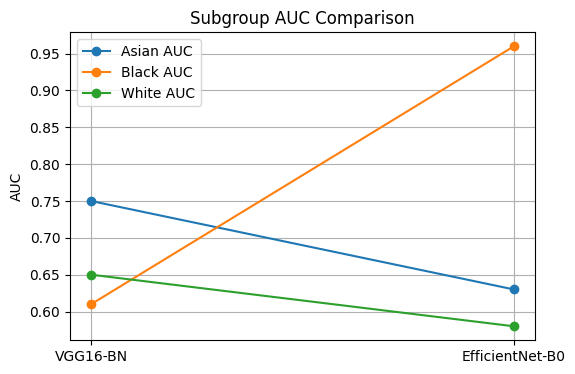

In [ ]:
#Visualize the results
import matplotlib.pyplot as plt

# Data
models = ["VGG16-BN", "EfficientNet-B0"]
asian = [0.75, 0.63]
black = [0.61, 0.96]
white = [0.65, 0.58]

x = range(len(models))

plt.figure(figsize=(6,4))
plt.plot(x, asian, marker='o', label="Asian AUC")
plt.plot(x, black, marker='o', label="Black AUC")
plt.plot(x, white, marker='o', label="White AUC")
plt.xticks(x, models)
plt.ylabel("AUC")
plt.title("Subgroup AUC Comparison")
plt.legend()
plt.grid()
plt.show()